# RH4.0 - UA & Sisqual
## Creating a calendar

This is a notebook to create a calendar associating each day in a given year with the most similar days in previous years. 
To find whether two days in different years are similar, temporal criteria and historical data are used.
There are two possible goals:
1. replicate Sisqual's forecasting method to compare results more easily;
1. to fine tune the algorithm to find the equivalent days.

The source dataset is a materialized view *MViewTickets_daily* in *2- Base de dados atualizada*. The main calculations are performed using SQL queries. To improve performance, materialized views and indexes are used. It is expected that this solution will be able to perform the calculations quickly, but if the response times are not satisfactory, it will be necessary to restructure the code, for example, by storing data in memory.

### Read a dataset from SQL Server
The scripts to prepare the data tables are in 'datasets/2- Base de dados atualizada/createMAterializedViews.sql'.

*Remarks*

1. We only need the columns rostercode, eventdate and tickets. The other columns are ignored. They can be used later, in case we decide to implement all code in Transact-SQL.

1. It may be a good idea to use a numeric index (surrogate key) instead of eventDate or (rostercode, eventDate)

In [11]:
import pandas as pd
import pyodbc as odbc

sql_conn = odbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=deti-sql-aulas.ua.pt;DATABASE=sisqualFORECASTDATA;UID=sisqual;PWD=projua;')

query = "SELECT * FROM MViewTickets_daily"
df = pd.read_sql(query, sql_conn)
print(df.head())
print("List of rostercodes: ", df["Rostercode"].unique())

myRostercode = "1027" # use this variable to choose the store / rostercode. 

#df.dtypes # the data type of eventDate is object


  Rostercode   eventDate  year  month  day  dayOfWeek  dayOfYear  week  \
0       1027  2018-01-02  2018      1    2          3          2     1   
1       1027  2018-01-03  2018      1    3          4          3     1   
2       1027  2018-01-04  2018      1    4          5          4     1   
3       1027  2018-01-05  2018      1    5          6          5     1   
4       1027  2018-01-06  2018      1    6          7          6     1   

   firstOfMonth  lastOfMonth weekOfMonth  holiSpecialDay  season  tickets  
0          True        False           1               0       0      419  
1          True        False           1               0       0      364  
2          True        False           1               0       0      442  
3          True        False           1               0       0      464  
4          True        False           1               0       0      386  
List of rostercodes:  ['1027' '259' '274' '290' '387' '409' '411' '432' '563' '599' '61']


### (Alternative) Read a dataset from an Excel document (to do...)

... but we need to calculate the derived columns. So the best option is to migrate the code in 'datasets/2- Base de dados atualizada/createMAterializedViews.sql' to Python, so that the same function will do the job for both cases.

In [12]:
#import pandas as pd
#from IPython.display import display
#df = pd.read_excel(r'C:\Users\José moreira\Documents\Investigacao\P2020_SISQUAL_RH4.0\Desenvolvimento\SISQUAL-data-and-methods\Construcao calendario\sisqualFORECASTDATA.xlsx', sheet_name='view_Sales') 
#display(df.head())


### Prepare the datasets

In [3]:
#df.types
#df.index

from datetime import timedelta, date

df.reset_index(inplace=True)
df.set_index(["Rostercode", "eventDate"], inplace=True)

#dfPreviousYears = df.query("year==2019").copy()
#dfPreviousYears.reset_index(inplace=True)
#dfPreviousYears.set_index(["Rostercode", "eventDate"], inplace=True)

#dfCurrentYear = df.query("year>=2020").copy()
#dfCurrentYear.reset_index(inplace=True)
#dfCurrentYear.set_index(["Rostercode", "eventDate"], inplace=True)

#dfPreviousYears.index

### Compute statistics and outliers
First we find the average and standard deviation of tickets by rostercode and day of week. We consider and outlier when $tickets \notin [\mu - 3 \sigma, \mu + 3 \sigma] $ (this means that the number of outliers would be, by definition and assuming a normal distribution,  $\sim 0.23\%$). This is a quite simple strategy to find outliers that needs improvement in the future. 

**We will also need to apply a similar procedure to find the outliers by hour.**

In [13]:
df.reset_index(inplace=True)
df.set_index(["eventDate"], inplace=True)
stats = df[["Rostercode", "year", "dayOfWeek", "tickets"]].groupby(by=["Rostercode", "year", "dayOfWeek"]).agg(["min", "max", "mean", "std"])

print(stats)

#min = stats.loc[ ("1027", 2018, 1) ][0]
#max = stats.loc[ ("1027", 2018, 1) ][1]
#mean = stats.loc[ ("1027", 2018, 1) ][2]
#std = stats.loc[ ("1027", 2018, 1) ][3]
#print(stats.loc[('1027', 2019, 1)][0])

df.reset_index(inplace=True)
df.set_index(["Rostercode", "eventDate"], inplace=True)

#### This is a simple function to detect outliers. It coulld be implemented as a lambda function. 
def isOutlier(r):  # r is a tuple(rostercode, timestamp), e.g., ('1027', Timestamp('2019-01-02 00:00:00'))
    if (r[0], r[1]) in df.index:
        x = df.loc[(r[0], r[1] )].tickets
        yMean = stats.loc[ (r[0], r[1].date().year, r[1].dayofweek + 1) ][2]
        yStd = stats.loc[ (r[0], r[1].date().year, r[1].dayofweek + 1) ][3]
        return(x < yMean - 3*yStd or x > yMean + 3*yStd)
    return False

# Can also be called as follows, but not necessary in this script
#dfPreviousYears["isOutlier"] = dfPreviousYears.index.map(lambda row: isOutlier(row))
#dfPreviousYears

                          tickets                             
                              min  max        mean         std
Rostercode year dayOfWeek                                     
1027       2018 1              81  495  233.560976  128.487752
                2              -1  636  505.744186  109.071207
                3              -1  640  496.500000  135.712977
                4             364  653  538.142857   59.041354
                5             173  654  554.950000   98.105895
...                           ...  ...         ...         ...
61         2020 3             334  578  446.333333   71.096017
                4             349  592  465.666667   65.916004
                5             346  671  497.290323   89.378668
                6             313  678  522.193548   86.331307
                7             328  649  490.733333   75.486438

[200 rows x 4 columns]


### Create a time dimension
The time dimension is created as a Pandas's data frame. We have two additional data structures (dictionaries), one to record the holidays and spacial days, and the other to record special seasons (time intervals which are actually discretized). these disctionaries could also be implemented as data frames (so we can hab)

*Remark*

1. The current implementation only supports one rostercode at a time. This should be improved in the future.

In [52]:
from datetime import date

holiSpecialDays = {}
# Fixed date
holiSpecialDays[date(2020, 1, 1)]   = (1, "Ano novo", True)             # True means it is a rest day  
holiSpecialDays[date(2020, 1, 6)]   = (2, "Dia de reis", False)
holiSpecialDays[date(2020, 2, 14)]  = (20, "Dia dos namorados", False)  # False means it is a working day
holiSpecialDays[date(2020, 12, 31)] = (40, "Passagem do ano", True)

holiSpecialDays[date(2019, 1, 1)]   = (1, "Ano novo", True)
holiSpecialDays[date(2019, 1, 6)]   = (2, "Dia de reis", False)
holiSpecialDays[date(2019, 2, 14)]  = (20, "Dia dos namorados", False)
holiSpecialDays[date(2019, 12, 31)] = (40, "Passagem do ano", True)

# Variable date
holiSpecialDays[date(2020, 4, 10)] = (101, "Sexta-feira santa", False)
holiSpecialDays[date(2020, 4, 12)] = (102, "Páscoa", True)

holiSpecialDays[date(2019, 4, 21)] = (101, "Sexta-feira santa", False)
holiSpecialDays[date(2019, 4, 19)] = (102, "Páscoa", True)


seasons = {}
# Fixed date
seasons[date(2020, 12, 28)] = (10, "Passagem do ano")
seasons[date(2020, 12, 29)] = (10, "Passagem do ano")
seasons[date(2020, 12, 30)] = (10, "Passagem do ano")
seasons[date(2020, 12, 31)] = (10, "Passagem do ano")

seasons[date(2019, 12, 28)] = (10, "Passagem do ano")
seasons[date(2019, 12, 29)] = (10, "Passagem do ano")
seasons[date(2019, 12, 30)] = (10, "Passagem do ano")
seasons[date(2019, 12, 31)] = (10, "Passagem do ano")

# Variable date
seasons[date(2020, 3, 27)] = (101, "Semana anterior a férias da Páscoa")
seasons[date(2020, 3, 28)] = (101, "Semana anterior a férias da Páscoa")
seasons[date(2020, 3, 29)] = (101, "Semana anterior a férias da Páscoa")
seasons[date(2020, 3, 30)] = (101, "Semana anterior a férias da Páscoa")
seasons[date(2020, 3, 31)] = (101, "Semana anterior a férias da Páscoa")
seasons[date(2020, 4, 1)] = (101, "Semana anterior a férias da Páscoa")
seasons[date(2020, 4, 2)] = (101, "Semana anterior a férias da Páscoa")

seasons[date(2020, 4, 3)] = (100, "Férias da Páscoa")
seasons[date(2020, 4, 4)] = (100, "Férias da Páscoa")
seasons[date(2020, 4, 5)] = (100, "Férias da Páscoa")
seasons[date(2020, 4, 6)] = (100, "Férias da Páscoa")
seasons[date(2020, 4, 7)] = (100, "Férias da Páscoa")
seasons[date(2020, 4, 8)] = (100, "Férias da Páscoa")
seasons[date(2020, 4, 9)] = (100, "Férias da Páscoa")

seasons[date(2019, 4, 5)] = (101, "Semanananterior a férias da Páscoa")
seasons[date(2019, 4, 6)] = (101, "Semanananterior a férias da Páscoa")
#seasons[date(2019, 4, 7)] = (101, "Semanananterior a férias da Páscoa")
#seasons[date(2019, 4, 8)] = (101, "Semanananterior a férias da Páscoa")
seasons[date(2019, 4, 9)] = (101, "Semanananterior a férias da Páscoa")
seasons[date(2019, 4, 10)] = (101, "Semanananterior a férias da Páscoa")
seasons[date(2019, 4, 11)] = (101, "Semanananterior a férias da Páscoa")

seasons[date(2019, 4, 12)] = (100, "Férias da Páscoa")
seasons[date(2019, 4, 13)] = (100, "Férias da Páscoa")
seasons[date(2019, 4, 14)] = (100, "Férias da Páscoa")
seasons[date(2019, 4, 15)] = (100, "Férias da Páscoa")
seasons[date(2019, 4, 16)] = (100, "Férias da Páscoa")
seasons[date(2019, 4, 17)] = (100, "Férias da Páscoa")
seasons[date(2019, 4, 18)] = (100, "Férias da Páscoa")

# gets the number of tickets for given rostercode and date
# example: print(df.loc[("61", date(2019, 4, 1))])
def getTickets(r):  # r is a tuple(rostercode, timestamp), e.g., ('1027', Timestamp('2019-01-02 00:00:00'))
    dateSTR = r[1].strftime('%Y-%m-%d')
    if (r[0], dateSTR) in df.index:
        return df.loc[(r[0], dateSTR )].tickets
    return None                                                   
   
def create_calendar(myRostercode, start='2020-01-01', end='2020-12-31'):
    start_ts = pd.to_datetime(start).date()

    end_ts = pd.to_datetime(end).date()

    # record timetsamp is empty for now
    dates =  pd.DataFrame(#columns=['Record_timestamp'],
        index=pd.date_range(start_ts, end_ts))
    dates.index.name = 'date'

    dayNames = {
        i: name
        for i, name
        in enumerate(['Monday', 'Tuesday', 'Wednesday',
                      'Thursday', 'Friday', 'Saturday', 
                      'Sunday'])
    }

    dates['rostercode'] = dates.index.map(lambda idx: myRostercode) 
    dates['dayOfWeek'] = dates.index.dayofweek.map(dayNames.get)
    dates['year'] = dates.index.year
    dates['month'] = dates.index.month
    dates['day'] = dates.index.day
    dates['dayOfWeekId'] = dates.index.dayofweek
    dates['dayofyear'] = dates.index.dayofyear
    #dates['week'] = dates.index.isocalendar().week
    dates['firstOfMonth'] = dates.index.day.map(lambda d: True if d <=7 else False)
    dates['lastOfMonth'] = dates.index.day > dates.index.daysinmonth - 7
    dates['weekOfMonth'] = dates.index.day // 7 + 1 
    dates['holiSpecialDay'] = dates.index.map(lambda d: holiSpecialDays[d.date()][0] if d.date() in holiSpecialDays else 0) 
    dates['specialDescription'] = dates.index.map(lambda d: holiSpecialDays[d.date()][1] if d.date() in holiSpecialDays else "")  
    dates['season'] = dates.index.map(lambda d: seasons[d.date()][0] if d.date() in seasons else 0)    
    dates['seasonDescription'] = dates.index.map(lambda d: seasons[d.date()][1] if d.date() in seasons else "")
    dates['isOutlier'] = dates.index.map(lambda d: isOutlier( (myRostercode, d) ) )
    dates['tickets'] = dates.index.map(lambda d: getTickets( (myRostercode, d) ) )
    dates.reset_index(inplace=True)
    dates.set_index("date", inplace=True)

    return dates 


### Create two calendars (current and previous) modelled as time dimensions

In [53]:
currentYear  = create_calendar(myRostercode, start='2020-01-01', end='2020-12-31')
previousYear = create_calendar(myRostercode, start='2019-01-01', end='2019-12-31')


### Create a dictionary assigning each date in the current year to dates in the previous years
The *key* is a date and *value* is a list of equivalent days. The list of equivalent days is empty. The parameter are 'global' variables. This is fine in this example that is implemented as a script, but they should be passed as parameters in a final implementation.

*Remarks*

1. The current solution only looks for outliers in regular days. It is assumed that the values of special days (holidays, seasons and first and last of month) do not agree with the usual pattern. In the future we can investigate different formulas according to those days or periods.

1. The date 29/02 is a special case: it is transformed to 28/02. This implies that one day can have several equivalent days and we must compute the average of these values to do an estimation.

1. This solution uses casting operators on dates, increasing the complexity of the code. There is possibly a simpler solution.

In [55]:
import numpy as np
from statistics import mean 
# print(holiSpecialDays.keys())
# initialize the dictionary

# Some variables are 'global' but in a final implementation they should given as parameters
myPreviousYear = 2019   # 'training" data'
myCurrentYear  = 2020   # 'test' data   

# script to create a dictionary with 365/366 days
equiDays = {}
for k, v in currentYear.iterrows():
    equiDays[k.date()] = []

# Function to find the equivalent days for a given date. This function ignores outliers in certain (pre-defined) cases 
def findEquivalentDay(refDate):

    d = currentYear.loc[str(refDate)]
    #print(d.tickets)

    # same special day. e.g., Christmas
    if d.holiSpecialDay > 0:
        equivDay = previousYear.query("holiSpecialDay ==" + str(d.holiSpecialDay))
        return list(equivDay.index.date)                              # Conversion to a list because the previous query may return more than one date (e.g., errors in filling in calendars)
    
    # Feb 29 is a special case and it is handled in the last of month section of this algorithm
    # if refDate.month == 2 and refDate.day == 29:
    #    return [date(myPreviousYear, 2, 28)]

    # same season returns the same weekday or the closets weekday or the average of the season (otherwise)
    if d.season > 0:                                                         # returns the same day of week
        equivDay = previousYear.query("season ==" + str(d.season) + "and dayOfWeekId == " + str(d.dayOfWeekId))
        if len(equivDay) > 0:
            return list(equivDay.index.date)
        else:                                                         # returns the next day of week
            next_dw = (d.dayOfWeekId + 1) if d.dayOfWeekId < 7 else 1 
            equivDay = previousYear.query("season ==" + str(d.season) + "and dayOfWeekId == " + str(next_dw))
            if len(equivDay) > 0:
                return list(equivDay.index.date)
            else:                                                     # returns the previous day of week
                prev_dw = (d.dayOfWeekId - 1) if d.dayOfWeekId > 1 else 7 
                equivDay = previousYear.query("season ==" + str(d.season) + "and dayOfWeekId == " + str(prev_dw))
                if len(equivDay) > 0:
                    return list(equivDay.index.date)
                else:                                                 # returns all days of season
                    equivDay = previousYear.query("season ==" + str(d.season))
                    if len(equivDay) > 0:
                        return list(equivDay.index.date)
                    else:                                             # otherwise handle it as a regular day
                        ...
                        
    # first of month
    if d.firstOfMonth == True:                                        # returns the date of the first day of week of that month
        equivDay =  previousYear.query("year == " + str(myPreviousYear) + " and month == " + str(d.month) + " and dayOfWeekId == " + str(d.dayOfWeekId) + " and firstOfMonth == True and holiSpecialDay == 0")
        if (len(equivDay) > 0):
            return list(equivDay.index.date)
        else:                                                         # otherwise handle it as a regular day
            ...
    
    # last of month
    if d.lastOfMonth == True:                                         # returns the date of the last matching day of week of that month
        equivDay =  previousYear.query("year == " + str(myPreviousYear) + " and month == " + str(d.month) + " and dayOfWeekId == " + str(d.dayOfWeekId) + " and lastOfMonth == True and holiSpecialDay == 0")
        if (len(equivDay) > 0):
            return list(equivDay.index.date)
        else:                                                         # otherwise handle it as a regular day
            ...
    
    # general case: the estimaded value is equal to the average of the tickets (or other measure) for that day of week during the corresponding month. Special days are ignored to not  bias the results,
    equivDay = previousYear.query("isOutlier == False and year == " +str(myPreviousYear) + " and month == " + str(d.month) + "and dayOfWeekId == " + str(d.dayOfWeekId) + " and firstOfMonth == False and lastOfMonth == False and holiSpecialDay == 0")
    return list(equivDay.index.date)


# computes the mean of the equivalent days for a given date
def estimate(d):                     # [datetime.date(2019, 1, 1)]
    ticketsList = [ getTickets( (myRostercode, k) ) for k in equiDays[d.date()] ]
    ticketsList = [ float(x) for x in ticketsList if x != None ]
    if len(ticketsList) > 0:
        return mean(ticketsList)
    return None

    
# Calls the function for each day in the calendar
def createEquivalences():  
    for k in equiDays.keys():
        equiDays[k].extend(findEquivalentDay(k))

createEquivalences()
# check if there are dates without equivalent days
print("Dates without a matching: ", [k for k in equiDays.keys() if len(equiDays[k]) == 0])
#print(equiDays)

# forecasting result
currentYear["estimated"] = currentYear.index.map(lambda d: estimate(d) )
currentYear["eventdate"] = currentYear.index.map(lambda d: d)

Dates without a matching:  [datetime.date(2020, 1, 13), datetime.date(2020, 1, 20), datetime.date(2020, 2, 10), datetime.date(2020, 2, 17), datetime.date(2020, 3, 9), datetime.date(2020, 3, 16), datetime.date(2020, 3, 23), datetime.date(2020, 5, 11), datetime.date(2020, 5, 18), datetime.date(2020, 8, 10), datetime.date(2020, 8, 17), datetime.date(2020, 8, 24), datetime.date(2020, 9, 14), datetime.date(2020, 9, 21), datetime.date(2020, 10, 12), datetime.date(2020, 10, 19), datetime.date(2020, 11, 9), datetime.date(2020, 11, 16), datetime.date(2020, 11, 23)]


### Plot results

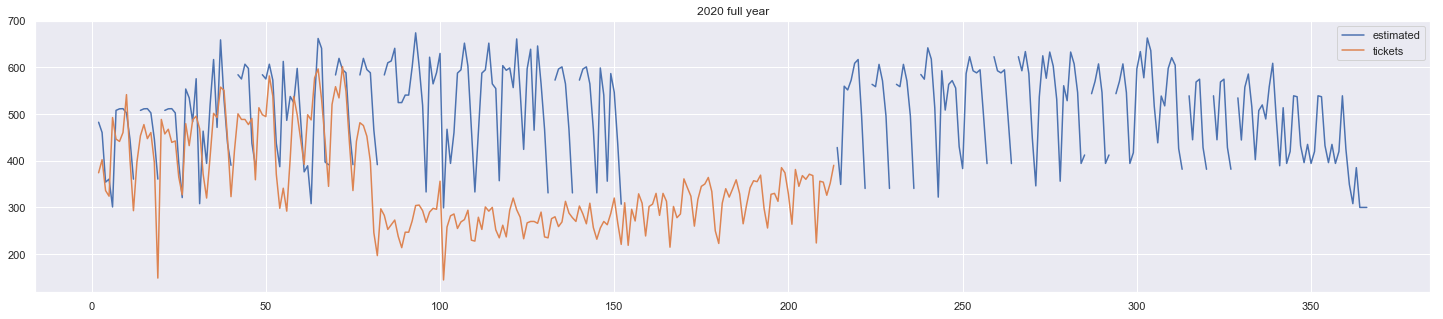

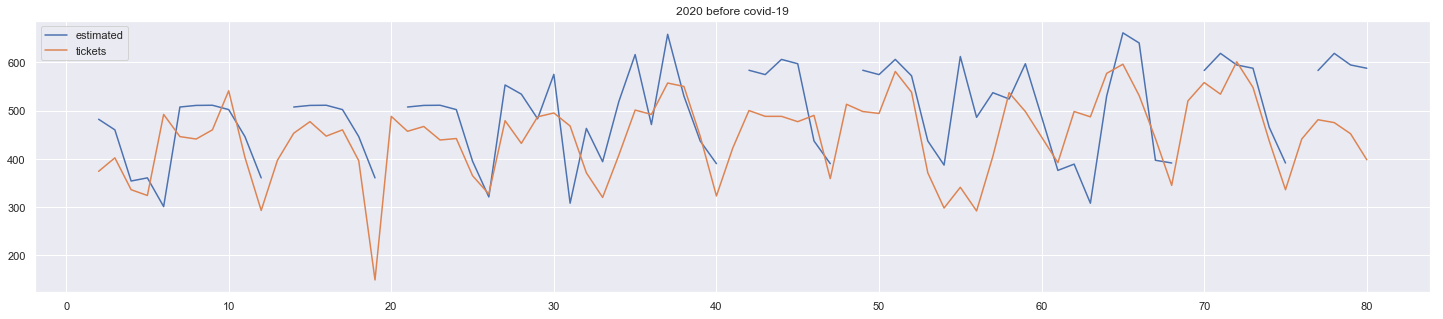

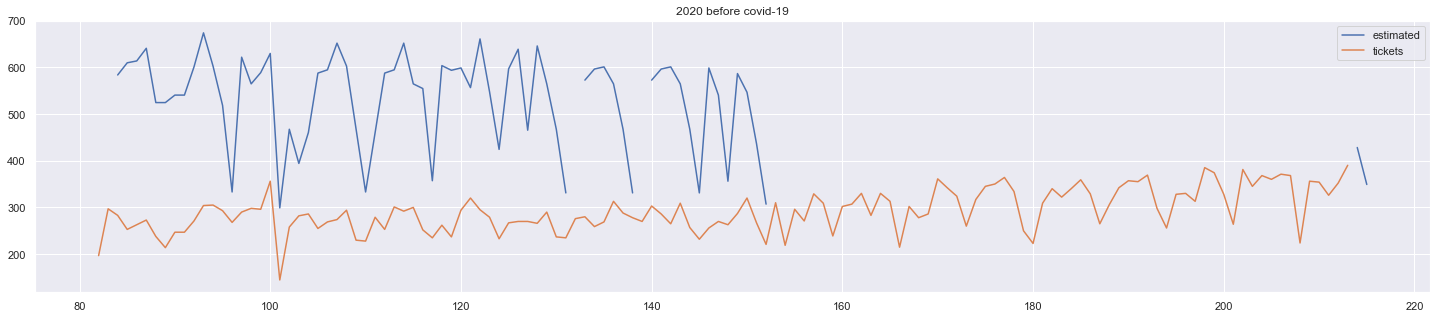

In [81]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 5))
#sns.lineplot('dayofyear', 'estimated', data=currentYear)
#sns.lineplot('dayofyear', 'tickets', data=currentYear)

plt.plot('dayofyear', 'estimated', data=currentYear)
plt.plot('dayofyear', 'tickets', data=currentYear)
#mask = currentYear["isOutlier"]
#plt.plot('dayofyear[mask]', 'tickets[mask]', data=currentYear)

plt.title("2020 full year")
plt.legend()

print("There is a gap in the estimated values probably due to None values")


plt.figure(figsize=(25, 5))
#sns.lineplot('dayofyear', 'estimated', data=currentYear)
#sns.lineplot('dayofyear', 'tickets', data=currentYear)

plt.plot('dayofyear', 'estimated', data=currentYear.iloc[1:80])
plt.plot('dayofyear', 'tickets', data=currentYear.iloc[1:80])

plt.title("2020 before covid-19")
plt.legend()


plt.figure(figsize=(25, 5))
#sns.lineplot('dayofyear', 'estimated', data=currentYear)
#sns.lineplot('dayofyear', 'tickets', data=currentYear)

plt.plot('dayofyear', 'estimated', data=currentYear.iloc[81:215])
plt.plot('dayofyear', 'tickets', data=currentYear.iloc[81:215])

plt.title("2020 during covid-19")
plt.legend()

### Display statistics

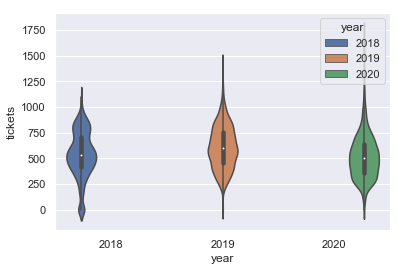

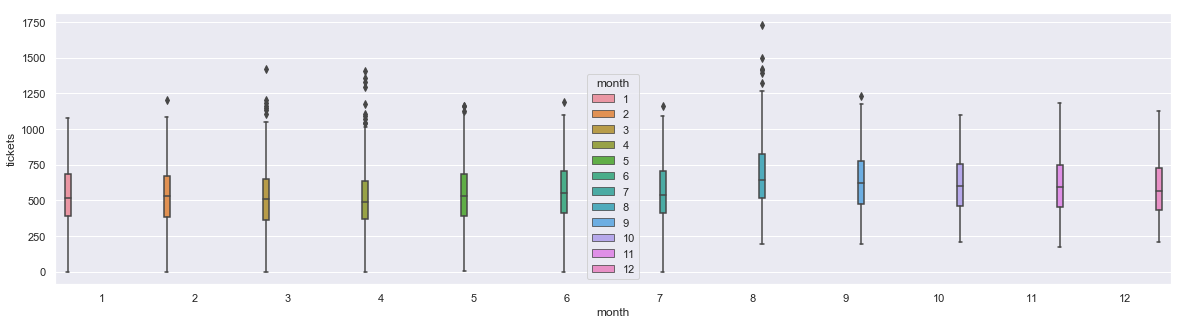

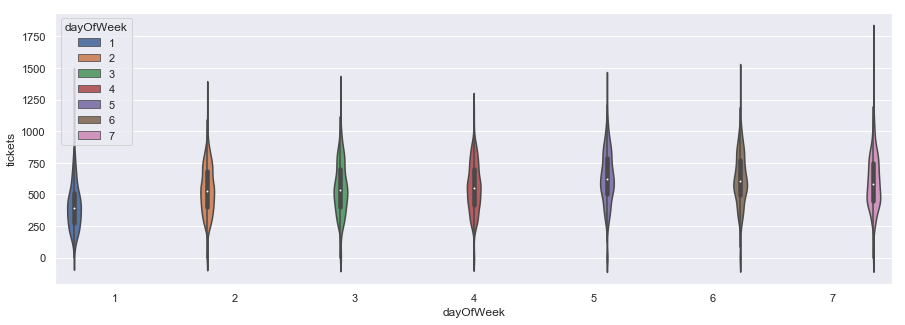

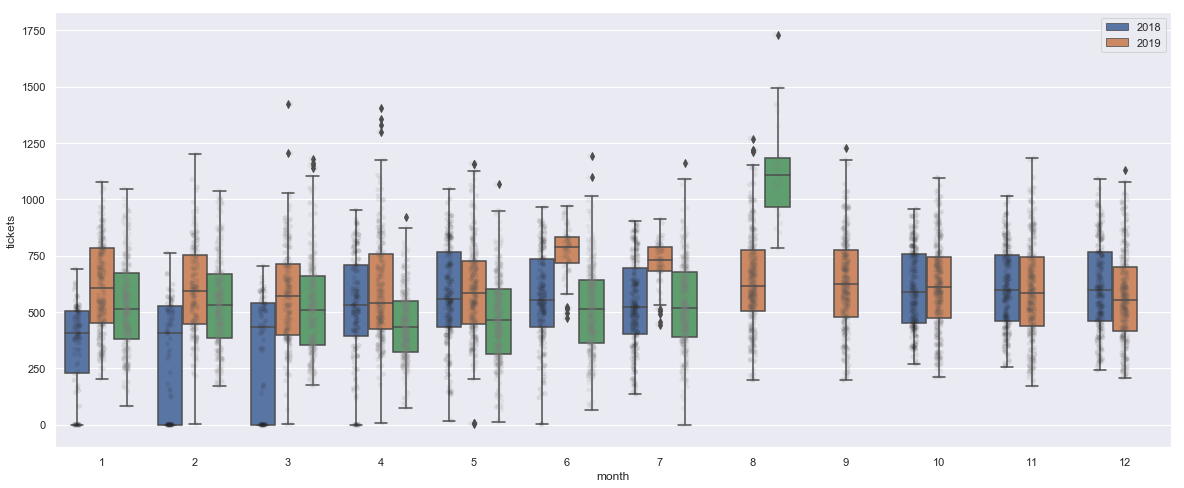

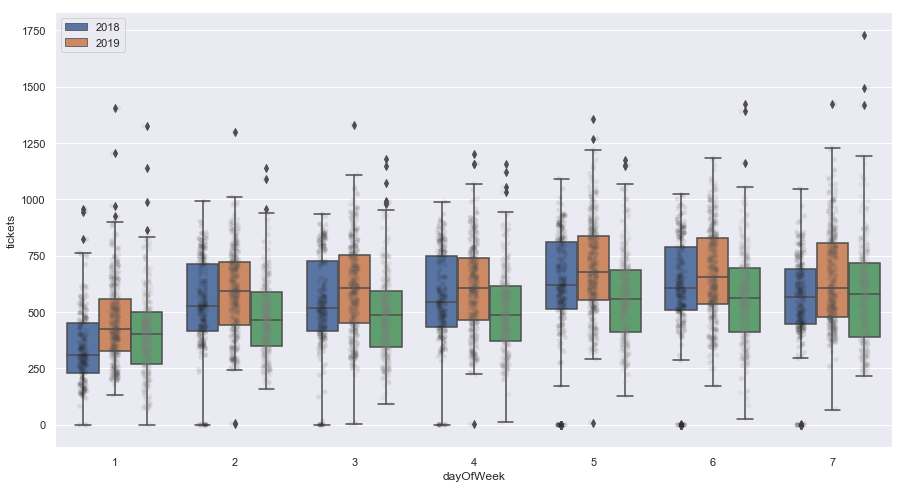

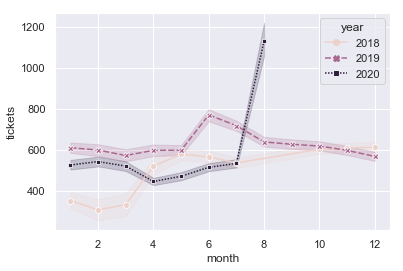

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

#### stats by year
plt.figure()
sns.violinplot(data=df, x="year", y="tickets", hue="year", inner="box")

#### stats by month
plt.figure(figsize=(20, 5))
sns.boxplot(data=df, x="month", y="tickets", hue="month")

#### stats by day of Week
plt.figure(figsize=(15, 5))
sns.violinplot(data=df, x="dayOfWeek", y="tickets", hue="dayOfWeek")

#### stats by month and year
plt.figure(figsize=(20, 8))
bp = sns.boxplot(data=df, x="month", y="tickets", hue="year")
sp = sns.stripplot(data=df, x="month", y="tickets", hue="year", dodge=True, marker='o', alpha=0.1, jitter=True, color='grey') 
# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2])

#### stats by weekday and year
plt.figure(figsize=(15, 8))
bp = sns.boxplot(data=df, x="dayOfWeek", y="tickets", hue="year")
sp = sns.stripplot(data=df, x="dayOfWeek", y="tickets", hue="year", dodge=True, marker='o', alpha=0.1, jitter=True, color='grey') 
# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2])

#### stats by year and month
plt.figure()
sns.lineplot(data=df, x="month", y="tickets", hue="year", markers=True, style="year")


# Pandas examples

In [60]:
x =  create_date_table(start='2020-02-20', end='2020-12-31')
x

NameError: name 'create_date_table' is not defined

In [61]:
df.index[1][1]
#df.columns

Timestamp('2018-01-03 00:00:00')

### Slicing

In [67]:
import numpy as np
dates = pd.date_range('1/1/2000', periods=8)
xdf = pd.DataFrame(np.random.randn(8, 4), index=dates, columns=['A', 'B', 'C', 'D'])

s = xdf["A"]
s[dates[5]]

xdf[["B"]] = xdf[["C"]]
xxdf = xdf[["A", "B", "D"]]

xxdf



,A,B,D
2000-01-01,1.143880,0.822983,0.373019
2000-01-02,-0.211826,-0.972748,-0.131816
2000-01-03,-0.365368,0.800331,1.009334
2000-01-04,0.470500,-0.040105,-1.329415
2000-01-05,-0.206976,-0.890617,-0.289266
2000-01-06,0.564573,-1.154606,0.101304
2000-01-07,-2.876083,0.903913,-1.782990
2000-01-08,0.549972,-0.901541,0.165683


In [ ]:
sa = pd.Series([1, 2, 3], index=list('abc'))
dfa = xdf.copy()

In [ ]:
dfa["A"] = range(1,9)


### Indexing

In [68]:
z = pd.DataFrame({'x': [1, 2, 3], 'y': [3, 4, 5]})
z.iloc[1] = {'x': 9, 'y': 99}
z[0] ={22, 19, 199}
z.iloc[0] ={22, 19, 199}
print(z["y"])

#this syntax works only for the rows
z[:2]
z.iloc[:1]


0    22
1    99
2     5
Name: y, dtype: int64


,x,y,0
0,19,22,199


In [ ]:
#Every label asked for must be in the index, or a KeyError will be raised.
#Integers are valid labels, but they refer to the label and not the position
dfl = pd.DataFrame(np.random.randn(5, 4),
                   columns=list('ABCD'),
                   index=pd.date_range('20130101', periods=5))

dfl.loc['20130102':]

xdf.loc['2000-01-02' : '2000-01-04', "C":] 
#xdf.iloc[2:, 2:]

idx = xdf.loc['2000-01-02' : , "A"] > 0
xdf.loc[:, "A"] 

In [ ]:
xdf.iloc[3:]

In [ ]:
df1 = pd.DataFrame(np.random.randn(6, 4),
      index=list('abcdef'),
      columns=list('ABCD'))

df1.loc[lambda df: df['A'] > 0, :]
xdf.loc[lambda df: df['A'] > 0, "B":]
xdf["A"].iloc[3:6]

In [ ]:
df.loc[('1027', '2018-01-02')]

### Querying examples

In [ ]:
import numpy as np
n = 10
dfc = pd.DataFrame(np.random.rand(n, 3), columns=list('abc'))
dfc[dfc["a"] < dfc["b"]]
dfc.query("a < b")

In [ ]:
currentYear.query("month == 2")

# Other

### Alternative to create a calendar

In [ ]:
myCalendar = {}
start = date(2020, 1, 1)
nDays = 366

for n in range(nDays):
    myCalendar[start + timedelta(n)] = []
